# Information Retreival Project
## Phase 1

In this project we trying to make an inverted index for news webpages with two approch and calculating *zipf* and *heaps* metrics.

### Level 1
1. Reterevie News
2. Data cleansing
3. Remove stopwords
4. Tokenize
5. Create Inverted Index
6. Measure heaps and zipf


### Level 2
1. Reterevie News
2. Data cleansing
3. Normalization
4. Stemming
3. Remove stopwords
4. Tokenize
5. Create Inverted Index
6. Measure heaps and zipf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Import Libraries

In [ ]:
!pip install parsivar
!pip install hazm
!pip install PersianStemmer
!pip install nltk==3.4.5

     |████████████████████████████████| 36.2MB 108kB/s 
     |████████████████████████████████| 1.5MB 43.2MB/s 
  Created wheel for parsivar: filename=parsivar-0.2.3-cp36-none-any.whl size=36492958 sha256=eca8dbf74d4dc7e4a757139fe5d021acd3ffe3bb2a3e2cf22831543b7a8427fe
  Stored in directory: /root/.cache/pip/wheels/b4/56/cd/29a045228c81c482429c711646af316ada1218f3029edce37c
  Created wheel for nltk: filename=nltk-3.4.5-cp36-none-any.whl size=1449905 sha256=5f6d90cf7cd9bfde00ebfea0b165f727d2ca2d8add17507b89b53dfd84359dde
  Stored in directory: /root/.cache/pip/wheels/96/86/f6/68ab24c23f207c0077381a5e3904b2815136b879538a24b483
Successfully built parsivar nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5
     |████████████████████████████████| 317kB 2.8MB/s 
     |████████████████████████████████| 1.4MB 8.7MB/s 
     |████████████████████████████████| 235kB 16.5MB/s 
  Created wheel for nltk: filename=nltk-3.3-cp36-none-a

In [ ]:
import os
from bs4 import BeautifulSoup
import pandas as pd
from pprint import pprint
import re
import numpy as np
import matplotlib.pyplot as plt
import random
import functools
import operator

pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  if sys.path[0] == '':


## Reterevie News and Data cleansing

In [ ]:
files = ['/content/drive/My Drive/IR/'+file for file in os.listdir('/content/drive/My Drive/IR/') if file.endswith('csv')]

In [ ]:
def remove_tags_and_scripts(text):
    soup = BeautifulSoup(text)
    [script.extract() for script in soup("script")]
    return BeautifulSoup(soup.get_text(), 'lxml').get_text()

In [ ]:
dfs = [pd.read_csv(file) for file in files]
df = pd.concat(dfs)
df['raw'] = df['content']
df['id'] = range(0,len(df))
df['content'] = df['content'].apply(remove_tags_and_scripts)
df['content'].replace(r'[؛:{}.,;#@!$%^&*!٬٫﷼٪×،*…»«-]', ' ', regex = True, inplace = True)
df['content'].replace(r'[\u200c\u061c]', ' ', regex = True, inplace = True)
df['content'].replace(r'\s', ' ', regex = True, inplace = True)

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.taghribnews.com/images/docs/files/000441/nf00441027-1.mp4" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.taghribnews.com/images/docs/files/000440/nf00440679-1.mp4" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.taghribnews.com/images/docs/files/000440/nf00440781-1.mp4" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an H

## Removing Stop words

In [ ]:
stops = open('/content/drive/My Drive/IR/stopwords.txt').read().split('\n')
df['words'] = df['content'].str.split(' ').apply(lambda x: [word for word in x if word not in stops]).dropna()

#### Save Dataframe for further loads

In [ ]:
df = df.set_index(df.id)
df.to_pickle('/content/drive/My Drive/IR/df2.pkl')
#df.to_csv('df.csv')

#### Load Dataframe from last session

In [ ]:
df = pd.read_pickle('/content/drive/My Drive/IR/df2.pkl')

## Make Dictionary and Inverted Index

In [ ]:
class IndexMaker:
    def __init__(self):
        self.dictionary = {}
        self.sorted_dictionary = []
        self.inverted_index = {}
        self.new_words = [[],[]]
        self.cnt = 0

    def add_cnt(self, i, w):
        self.dictionary[w] = self.dictionary[w] + 1 if w in self.dictionary.keys() else 1
        h_w = hash(w)
        if h_w in self.inverted_index.keys():
            self.inverted_index[h_w].add(i)
        else:
            self.cnt += 1
            self.inverted_index[h_w] = set([i])
    
    def add_to_dict(self, row):
        i = row.id
        wordlist = row.words
        self.cnt = 0
        [self.add_cnt(i, w) for w in wordlist]
        self.new_words[0].append(self.cnt)
        self.new_words[1].append(len(wordlist))
    
    # Sort a dictionary of word-frequency pairs in
    # order of descending frequency.
    def sortFreqDict(self):
        self.sorted_dictionary = [(self.dictionary[key], key) for key in self.dictionary]
        self.sorted_dictionary.sort()
        self.sorted_dictionary.reverse()
        
    def get_word(self, word):
        return self.inverted_index[hash(word)]

    def run(self, _df):
        _df.apply(self.add_to_dict, axis=1)
        self.sortFreqDict()
        return self.dictionary, self.sorted_dictionary, self.inverted_index, self.new_words

In [ ]:
ind = IndexMaker()
dictionary, sorted_dict, inverted_index, new_words = ind.run(df)

In [ ]:
sum([len(i) for i in inverted_index.values()])

7436483

### Test Dictionary and Inverted Index

In [ ]:
select = 10
word_and_freq = sorted_dict[select]
print('The word in place {} of dictionary'.format(select), word_and_freq)
print('Number of Files found in inverted index for the word {} is:'.format(word_and_freq[1]), len(ind.get_word(word_and_freq[1])))

The word in place 10 of dictionary (31083, 'بیان')
Number of Files found in inverted index for the word بیان is: 15768


## Zipf Law

In [ ]:
def zipf(sorted_dict):
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('log10 Rank')
    plt.ylabel('log10 Cf')
    K = sorted_dict[0][0]
    plt.plot([K/y for y in range(1,len(sorted_dict))], label='Predicted')
    plt.plot([x[0]/(i+1) for i, x in enumerate(sorted_dict)], label='Observed')
    plt.legend()

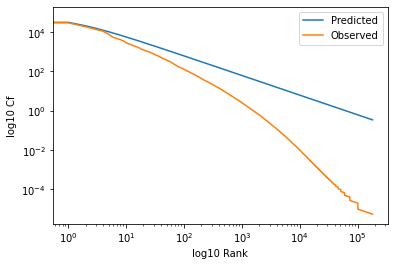

In [ ]:
zipf(sorted_dict)

## Heaps Law

In [ ]:
def flattern(a):
    return functools.reduce(operator.iconcat, a, [])

def heaps(df, col, t1, t2, new_words):
    sample_5T = flattern([df[df.id == i][col].to_list()[0] for i in random.sample(range(len(df)), t1)])
    sample_15T = flattern([df[df.id == i][col].to_list()[0] for i in random.sample(range(len(df)), t2)])
    M_5T = len(set(sample_5T))
    T_5T = len(sample_5T)
    M_15T = len(set(sample_15T))
    T_15T = len(sample_15T)

    b = (np.log10(M_15T) - np.log10(M_5T)) / (np.log10(T_15T) - np.log10(T_5T))
    k = M_5T / T_5T ** b
    print(k,b)

    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('log10T')
    plt.ylabel('log10M')
    plt.plot(range(new_words[1][0],sum(new_words[1])), [k*(i**b) for i in range(new_words[1][0],sum(new_words[1]))], label='Predicted')
    plt.plot(np.cumsum(new_words[1]), np.cumsum(new_words[0]), label='Observed')
    plt.legend()

In [ ]:
df

publish_date  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 words
id                                      ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
0      October 24th 2019, 21:37:00.000  ...  [نمایشنامه, ۱۳, ژوئیه", یوسف, فخرایی, الهام, نمایشنامه, مارا, ساد", پتر, وایس, نوشته, واقعه, ی, روز, قتل, ژان, پل, مارا, انقلابیون, فرانسه, دگرگونی, اجتماعی, سیاسی, دوره, پردازد, درک, نمایش, ابتدا, حتما, کمی, تاریخ, ورق, بزنیم, نمایش, برشی, تاریخ, انقلاب, فرانسه, نشانمان, ژان, پل, مارا, پزشک, سیاستمدار, نویسنده, انقلابی, فرانسوی, زاده, سوئیس, کنار, ژرژدانتون, ماکسیمیلین, روبسپیر, یکی, سه, چهره, سرشناس, انقلاب, فرانسه, سرانجام, جانش, انقلاب, گذاشت, صحنه, ۱۳, ژوئیه, فخرایی, خلاف, ماراساد", وایس, تیمارستان, گویا, گورستانی, رخ, بخشهایی, دکور, صحنه, نمایش, شبیه, تابوت, ژان, پل, فریادش, ملت, مرده, بیدار, شخصیتهای, نمایش, قبر, فراخوانده, تاریخ, بگویند, سرانجام, خشونت, جهل, استثمار, بازی, سیاسی, مزورانه, ...]                              
1      October 25th 2019, 11:09:00.000  ...  [حجت, الاسلام, مختار, کرمی, روز, جمعه, اعلام, خبر, خبرنگار, ایرنا, افزود, ترویج, سنت, حسنه, وقف, نمایشگاه, موضوعی, دستاوردهای, وقف, دهه, وقف, سطح, استان, برگزار, بیست, وهفتم, ماه, صفر, تقویم, رسمی, کشور, روز, وقف, آغاز, دهه, وقف, حجت, الاسلام, کرمی, بیان, دهه, وقف, روز, چهارم, آبان, جاری, آغاز, اظهار, سال, جاری, سال, گذشته, برنامه, متعددی, همزمان, دهه, سطح, استان, اجرا, مدیرکل, اوقاف, امور, خیریه, استان, زنجان, عنوان, نخستین, روز, دهه, وقف, وقف, بهره, وری, موقوفات, رونق, تولید, اعلام, وقف, ترویج, فرهنگ, قرآن, عترت, عنوان, روز, وقف, اجتماعی, اجرای, امینانه, نیات, واقفین, عنوان, روز, وقف, بقاع, متبرکه, زمینه, ساز, تحقق, گام, انقلاب, ...]                                                                                                 
2      October 24th 2019, 23:30:00.000  ...  [گزارش, گروه, بین, الملل, خبرگزاری, میزان, نتایج, نظرسنجی, جدید, اکثریت, رای, دهندگان, سیاه, پوست, آمریکا, خواستار, استیضاح, دونالد, ترامپ, رئیس, جمهور, کشور, همچنین, برکناری, سمت, ریاست, جمهوری, گزارش, نیوزویک, نظرسنجی, دانشگاه, Quinnipiac, ۸۲, درصد, رای, دهندگان, سیاه, پوست, دونالد, ترامپ, استیضاح, سمتش, برکنار, حالی, ۵۳, درصد, رای, دهندگان, اسپانیایی, تبار, ۴۲, درصد, رای, دهندگان, سفید, پوست, معیار, حمایت, نظر, رسد, دونالد, ترامپ, دستیابی, محبوبیت, میان, سیاه, پوستان, انتخابات, ریاست, جمهوری, ۲۰۲۰, چالشی, جدی, رو, رو, ۸۸, درصد, رای, دهندگان, سیاه, پوست, جامعه, آمریکا, عملکرد, کاری, عنوان, رئیس, جمهور, رضایت, نداشته, ۱۰, درصد, سیاه, پوستان, عملکرد, رضایت, بخش, حالی, دونالد, ترامپ, ...]                                            
3      October 24th 2019, 21:40:00.000  ...  [گزارش, گروه, اقتصادی, خبرگزاری, دانشجو, روح, الله,

22.746179952912506 0.5511888846283328


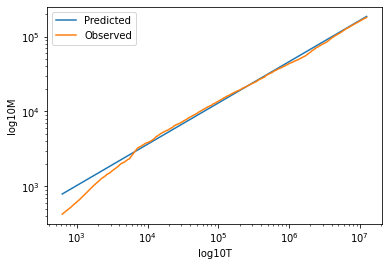

In [ ]:
heaps(df, 'words', 5000, 15000, new_words)

# LEVEL 2
## Normalization

In [ ]:
all_chars = set()
df.content.apply(lambda x : [all_chars.add(s) for s in x])
print(len(all_chars))
print(all_chars)

398
{'\u2060', 'ᴉ', 'ط', '۸', 't', 'V', 'j', 'ú', '🔷', '|', 'ﺳ', 'ﻊ', '्', 'ٌ', '=', 'R', '0', 'ﺸ', 'ﻛ', 'ē', 'U', 'ô', 'ۗ', 'N', 'ü', 'ˈ', 'ﻖ', 'ﻳ', '·', 'ك', 'ۆ', 'ِ', 'ﺄ', 'ﻲ', 'ﻢ', 'ﻒ', 'ﺹ', '•', 'ı', 'ﮒ', 'ﻀ', 'ء', 'ﺓ', '2', 'ﭗ', 'ە', 'ع', '◊', 'H', 'B', 'è', 'ﻜ', 'ž', 'ﻑ', '\u200f', 'ﮓ', '3', 'ة', 'ی', '8', ' ', 'ۀ', '۵', 'ٔ', 'ﺰ', 'ﺎ', '⏰', 'r', '[', 'ã', '←', 'و', 'E', '‹', 'س', 'ﻰ', 'ﻪ', 'ل', 'ﺬ', 'ਸ', 'ﺿ', '\x7f', 'Ü', 'ﺏ', 'd', 'ﻗ', 'َ', 'ٓ', 'ٗ', 'ﺒ', '\u2063', '9', 'ذ', 'w', 'ﺻ', '\uf1d8', 'ٱ', 'ٍ', 'ﺌ', '\u2066', ']', 'ﺮ', 'ئ', 'î', 'ٖ', 'پ', 'ۚ', 'ਖ', 'ﺕ', '⚽', 'ﮋ', 'K', 'é', 'أ', 'S', 'ﻴ', 'Z', 'ﻼ', '🕌', '\x9d', '5', 'a', 'ﺛ', '\ufeff', 'ϕ', 'گ', 'z', 'I', 'Q', 'ﻚ', '\u2067', 'ص', 'ک', 'چ', '`', '٧', '۱', '۲', '(', '¬', 'ﻔ', 'ﺽ', 'آ', 'ﺑ', 'श', 'ﻩ', 'ﺷ', 'ز', 'ﺭ', 'ݭ', 'o', 'ﯼ', '《', 'm', '￼', 'ﻞ', 'b', "'", 'ﻧ', 'ُ', '》', 'É', 'n', '˝', 'ﻤ', '٨', '€', 'ف', 'ﻐ', 'ş', 'ﷲ', '‘', 'ç', 'ﻌ', '<', 'f', '\u200e', '💠', '\u200b', 'ﺟ', 'ۢ', '٤', 'ﻟ', '\u2069', 'य', 'ﮏ', '٥', 'X',

In [ ]:
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
df.content.replace(emoji_pattern, ' ', regex = True, inplace = True)
df.content.replace(r'[\'\"\"()+/<=>?\[\]\\`|©¬°±·¼：�]', ' ', regex = True, inplace = True)
df.content.replace(r'[﴾﴿ˈ˝ϕ؟ًٌٍَُِّْٖٓٔٗٞ٭ٰۖۗۙۚۡۢۤۥ]', ' ', regex = True, inplace = True)
df.content.replace(r'['
                   '\x7f-\xad'
                   '\u200b-\uf1d8'
                   '\ufeff'
                   '\ufe0f'
                   '\ufffc'
                   '\u06e6'
                   '\u061c'
                   '\u06ed'
                   '\u092f-\u1e25'
                   ']', ' ', regex = True, inplace = True)


In [ ]:
mapper = []
mapper.append(('و', 'ﻮﻭؤوۆ'))
mapper.append(('ه','ﺓﻫﻪﻩةﻬھۀهہە'))
mapper.append(('ن','ﻨﻧﻦﻥنﺬ'))
mapper.append(('م','ﻤﻣﻢﻡم'))
mapper.append(('ل','ﻞﻠﻟﻝل'))
mapper.append(('ک','ﻜﻛﻚكﮑﮐﮏک'))
mapper.append(('ق','ﻗﻘﻖق'))
mapper.append(('ف','ﻓﻒﻑﻔف'))
mapper.append(('غ','ﻐﻏغ'))
mapper.append(('ع','ﻋﻉﻊﻌع'))
mapper.append(('ط','ﻃﻂﻄط'))
mapper.append(('ض','ﺿﻀﺽض'))
mapper.append(('ص','ﺻﺼﺹص'))
mapper.append(('ش','ﺸﺷﺶﺵشݭ'))
mapper.append(('س','ﺴﺳﺱﺲس'))
mapper.append(('ز','ﺰزﺯ'))
mapper.append(('ر','ﺮﺭر'))
mapper.append(('د','ﺪﺩد'))
mapper.append(('خ','ﺧﺨﺦخ'))
mapper.append(('ح','ﺣﺤح'))
mapper.append(('لا', 'ﻼﻻ'))
mapper.append(('ی','ﺋﻯﺌﻱﻲﻰﻳﻴئىيﯿﯾﯽﯼیے'))
mapper.append(('ج','ﺠﺞﺟج'))
mapper.append(('ث','ﺛث'))
mapper.append(('ت','ﺘﺖﺕﺗت'))
mapper.append(('ب','ﺒﺑﺐﺏ'))
mapper.append(('ا','ﺎﺄﺍأإاٱٲ'))
mapper.append(('آ','ﺁآ'))
mapper.append(('','ﺀـء'))
mapper.append(('الله','ﷲ'))
mapper.append(('ریال', '﷼'))
mapper.append(('ب','ب'))
mapper.append(('ذ','ذ'))
mapper.append(('ظ','ظﻈ'))
mapper.append(('گ','ﮕﮔﮓﮒگ'))
mapper.append(('ژ','ﮋژ'))
mapper.append(('چ','ﭽچﭼ'))
mapper.append(('پ','ﭙﭘﭗپ'))
mapper.append(('C','Ç'))
mapper.append(('E','É'))
mapper.append(('U','Ü'))
mapper.append(('a','áãāæ'))
mapper.append(('c','ç'))
mapper.append(('e','èēé'))
mapper.append(('i','íıî'))
mapper.append(('o','óöøô'))
mapper.append(('u','úü'))
mapper.append(('g','ğ'))
mapper.append(('z','ž'))
mapper.append(('s','şš'))
mapper.append(('0','٠۰'))
mapper.append(('1','١۱'))
mapper.append(('2','٢۲'))
mapper.append(('3','٣۳'))
mapper.append(('4','٤۴'))
mapper.append(('5','٥۵'))
mapper.append(('6','٦۶'))
mapper.append(('7','٧۷'))
mapper.append(('8','٨۸'))
mapper.append(('9','٩۹'))
mapper.append((' ','_'))

[df.content.replace(r'[{}]'.format(m[1]), m[0], regex = True, inplace = True) for m in mapper]
df.content = df.content.apply(lambda x : x.lower())
# df.content.replace(r'[0-9]', '', regex = True, inplace = True)

print(len(mapper))

61


In [ ]:
chars = set()
df.content.apply(lambda x : [chars.add(s) for s in x])
print(len(chars))


70


In [ ]:
l = list(zip(chars,[c.encode("unicode_escape") for c in chars]))
l.sort()
pprint(l)

[(' ', b' '),
 ('0', b'0'),
 ('1', b'1'),
 ('2', b'2'),
 ('3', b'3'),
 ('4', b'4'),
 ('5', b'5'),
 ('6', b'6'),
 ('7', b'7'),
 ('8', b'8'),
 ('9', b'9'),
 ('a', b'a'),
 ('b', b'b'),
 ('c', b'c'),
 ('d', b'd'),
 ('e', b'e'),
 ('f', b'f'),
 ('g', b'g'),
 ('h', b'h'),
 ('i', b'i'),
 ('j', b'j'),
 ('k', b'k'),
 ('l', b'l'),
 ('m', b'm'),
 ('n', b'n'),
 ('o', b'o'),
 ('p', b'p'),
 ('q', b'q'),
 ('r', b'r'),
 ('s', b's'),
 ('t', b't'),
 ('u', b'u'),
 ('v', b'v'),
 ('w', b'w'),
 ('x', b'x'),
 ('y', b'y'),
 ('z', b'z'),
 ('آ', b'\\u0622'),
 ('ا', b'\\u0627'),
 ('ب', b'\\u0628'),
 ('ت', b'\\u062a'),
 ('ث', b'\\u062b'),
 ('ج', b'\\u062c'),
 ('ح', b'\\u062d'),
 ('خ', b'\\u062e'),
 ('د', b'\\u062f'),
 ('ذ', b'\\u0630'),
 ('ر', b'\\u0631'),
 ('ز', b'\\u0632'),
 ('س', b'\\u0633'),
 ('ش', b'\\u0634'),
 ('ص', b'\\u0635'),
 ('ض', b'\\u0636'),
 ('ط', b'\\u0637'),
 ('ظ', b'\\u0638'),
 ('ع', b'\\u0639'),
 ('غ', b'\\u063a'),
 ('ف', b'\\u0641'),
 ('ق', b'\\u0642'),
 ('ل', b'\\u0644'),
 ('م', b'\\u0645'),
 (

### Seperating Numbers and Characters

In [ ]:
def seperate_num_chars(text):
    match = re.match(r"([a-zA-Z]+)([\u0600-\u06FF]+)", text, re.I) # First Latin then Persian
    if match:
        return match.groups()
    match = re.match(r"([\u0600-\u06FF]+)([a-zA-Z]+)", text, re.I) # First Persian then Latin
    if match:
        return match.groups()
    match = re.match(r"([a-zA-Z\u0600-\u06FF]+)([0-9]+)", text, re.I) # First Chars then Numbers
    if match:
        return match.groups()
    match = re.match(r"([0-9]+)([a-zA-Z\u0600-\u06FF]+)", text, re.I) # First Numbers then Chars
    if match:
        return match.groups()
    return text

def join_persian_expr(text):
    expr = open('/content/drive/My Drive/IR/expressions.txt').read().split('\n')
    expr2 = [e.replace(' ', '_') for e in expr]
    for e, e2 in list(zip(expr, expr2)):
        text = text.replace(e, e2)
    return text

## Stemming and Tokenize

In [ ]:
print(join_persian_expr('بنا بر این'))

بنا_بر_این


In [ ]:
from __future__ import unicode_literals
from PersianStemmer import PersianStemmer 
import parsivar
import hazm
ps = PersianStemmer()
my_stemmer = parsivar.FindStems()

df.content = df.content.apply(join_persian_expr)
token_hazm = df.content.apply(hazm.word_tokenize)
token_hazm = token_hazm.apply(lambda x : [seperate_num_chars(w) for w in x])
token_hazm.apply(lambda x : [x.extend(w) for w in x if isinstance(w, tuple)])

# stemmed_persian = token_hazm.apply(lambda x : [ps.run(w) for w in x if not isinstance(w, tuple)]) # For Words
# stemmed_parsivar = stemmed_persian.apply(lambda x : [my_stemmer.convert_to_stem(w) for w in x if not isinstance(w, tuple)]) # For verbs

id
0        []
1        []
2        []
3        []
4        []
         ..
55104    []
55105    []
55106    []
55107    []
55108    []
Name: content, Length: 55109, dtype: object

In [ ]:
## FOR REPORT
## گفت، گو، رود، رو، خواه، سپاس، هنر، شریف، دوست، یاد، توان، شنو، کرد، ساز، دان،

the_list_1 = ['گفت', 'گو', 'رود', 'رو', 'خواه', 'سپاس', 'هنر', 'شریف', 'دوست', 'یاد', 'توان', 'شنو', 'کرد', 'ساز', 'دان']
the_list_2 = ['گفت&گو', 'رود&رو', 'خواستن&خواه', 'توانستن&توان', 'شنیدن&شنو', 'کرد&کن', 'ساخت&ساز', 'دانستن&دان']
the_list_2.extend(the_list_1)
found = {}
def stem_1(ps, word):
    w = ps.run(word)
    if w in the_list_1:
      if w in found.keys():
        found[w].add(word)
      else:
        found[w] = set([word])
    return w
 
def stem_2(my_stemmer, word):
    w = my_stemmer.convert_to_stem(word)
    if w in the_list_2:
      if w in found.keys():
        found[w].add(word)
      else:
        found[w] = set([word])
    return w

stemmed_persian = token_hazm.apply(lambda x : [stem_1(ps, w) for w in x if not isinstance(w, tuple)]) # For Words
stemmed_parsivar = stemmed_persian.apply(lambda x : [stem_2(my_stemmer, w) for w in x if not isinstance(w, tuple)]) # For verbs

print(found)

{'یاد': {'یادتان', 'یادها', 'یادش', 'یادان', 'یادمان', 'یادم', 'یادشان', 'یادی', 'یادت', 'یاد'}, 'توان': {'توانند', 'توانان', 'توان', 'توانست', 'توانیی', 'بازتوانی'}, 'کرد': {'کردهام', 'کردهای', 'کردهاست', 'کرد', 'کردند', 'کردشان', 'کردیان', 'بازکرد', 'کردیانی', 'کردهایی', 'کردش', 'کردی', 'کردنده', 'کردت', 'کردم', 'کردمان', 'کردین', 'کردها'}, 'گفت': {'گفت'}, 'ساز': {'سازیان', 'سازان', 'سازهاست', 'سازانی', 'واسازی', 'سازیها', 'سازند', 'سازواره', 'سازانه', 'بازساز', 'سازست', 'سازیهای', 'ناساز', 'سازها', 'سازهایی', 'سازانش', 'سازهایشان', 'سازهای', 'سازی', 'پیشساز', 'سازم', 'سازترین', 'سازتر', 'ساز'}, 'رو': {'فرارو', 'روهای', 'روترهای', 'روباره', 'روهایی', 'روها', 'روترها', 'روهاست', 'روتر', 'روست', 'روین', 'رو', 'روت'}, 'دان': {'دانهای', 'دانها', 'دان', 'داننده', 'دانند', 'دانست', 'دانان', 'دانالو', 'دانم', 'دانی', 'دانهایی', 'دانانگ'}, 'دوست': {'دوستای', 'دوستانش', 'دوستمان', 'دوستانمان', 'دوستم', 'دوستت', 'دوستتان', 'دوست', 'دوستانشان', 'دوستانت', 'دوستانتان', 'دوستش', 'دوستان', 'دوستان

In [ ]:
df['stem'] = stemmed_parsivar

In [ ]:
stops = open('/content/drive/My Drive/IR/all.txt').read().split('\n')
stops = [ps.run(my_stemmer.convert_to_stem(w)) for w in stops] # Apply the same stemming changes on stop words ... just in case :D
df['stem'] = df['stem'].apply(lambda x: [word.replace('_', ' ') for word in x])
df['words'] = df['stem'].apply(lambda x: [word for word in x if word not in stops])

In [ ]:
ind2 = IndexMaker()
ind2.run(df)
pprint(ind2.sorted_dictionary)

Streaming output truncated to the last 5000 lines.
 (1, 'taranta'),
 (1, 'tapping'),
 (1, 'tapi'),
 (1, 'tank'),
 (1, 'tanap'),
 (1, 'tamin'),
 (1, 'tameem'),
 (1, 'tamasha'),
 (1, 'talent'),
 (1, 'talai'),
 (1, 'tak'),
 (1, 'taimyrsky'),
 (1, 'tahzib'),
 (1, 'tadabor'),
 (1, 'tabulating'),
 (1, 'tabrizkhat'),
 (1, 'systemes'),
 (1, 'sysmex'),
 (1, 'syrpetro'),
 (1, 'syr'),
 (1, 'syntax'),
 (1, 'syngas'),
 (1, 'syndrome'),
 (1, 'syncrolift'),
 (1, 'synchronize'),
 (1, 'symrise'),
 (1, 'syed'),
 (1, 'sybil'),
 (1, 'swot'),
 (1, 'switch'),
 (1, 'swedish'),
 (1, 'swansea'),
 (1, 'swahili'),
 (1, 'suzuki'),
 (1, 'suspending'),
 (1, 'surveyusa'),
 (1, 'surveying'),
 (1, 'surprise'),
 (1, 'surgery'),
 (1, 'surf'),
 (1, 'surendranath'),
 (1, 'supreme'),
 (1, 'support'),
 (1, 'sunny'),
 (1, 'sundys'),
 (1, 'sundays'),
 (1, 'sumy'),
 (1, 'summon'),
 (1, 'summer'),
 (1, 'suggests'),
 (1, 'suboptimal'),
 (1, 'sty'),
 (1, 'stx'),
 (1, 'stuff'),
 (1, 'studios'),
 (1, 'studies'),
 (1, 'stronger'),
 

In [ ]:
len(ind2.sorted_dictionary)

86108

['salam']

In [ ]:
def get(word):
  s = word.split(' ')
  if len(s) == 1:
    return ind2.get_word(s[0])
  else:
    return set(ind2.get_word(s[0])).intersection(ind2.get_word(s[1]))
    

In [ ]:
len(get('جنگ افزار'))

63

In [ ]:
get('جنگ افزار')

{461,
 1857,
 2419,
 2683,
 2802,
 4335,
 4576,
 4618,
 4624,
 6235,
 7368,
 7426,
 7711,
 8989,
 9530,
 10173,
 11837,
 12088,
 13775,
 15362,
 15563,
 15908,
 16227,
 18757,
 24018,
 27431,
 32802,
 33168,
 33469,
 33546,
 33950,
 34339,
 35031,
 35673,
 36451,
 36553,
 36555,
 36696,
 37121,
 38312,
 38456,
 39022,
 39356,
 39533,
 39714,
 40149,
 40765,
 42170,
 42932,
 43915,
 44642,
 45195,
 45422,
 47514,
 47957,
 49137,
 49303,
 51358,
 51561,
 53602,
 53881,
 54777,
 54861}

In [ ]:
zipf(ind2.sorted_dictionary)

In [ ]:
heaps(df, 'words', 5000, 15000, ind2.new_words)